## Packages

In [2]:
import numpy as np
from numpy import dot, array_equal, conj, matmul, real, sum, pi
from collections.abc import Iterable
from numpy.linalg import eig, inv
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.stats import norm
import sympy
from sympy import simplify, trigsimp, powsimp, factor, solve, Matrix, ImmutableDenseMatrix ,Symbol, symbols, I, cse, expand, sin, cos, diag, eye, Add, sqrt, lambdify, collect, conjugate, shape
from sympy.physics.quantum.dagger import Dagger


## Parameters

In [4]:
#Symbolic Variables
delta = Symbol(r"\Delta",real = True,positive = True) #m2**2 - m1**2
theta = Symbol(r"\theta",real = True,positive = True) #Mixing angle for 2x2 rotation matrix
A = Symbol(r"A",real = True,positive = True) #Potential

S = Symbol(r"S",real = True, positive = True) #Sterile neutrino potential

L = Symbol(r"L",real = True,positive = True) #Distance
E = Symbol(r"E",real = True,positive = True) #Energy

phase = Symbol(r"\delta",real = True) #Complex phase angle

phase14, phase24, phase13 = symbols(r"\delta_{14}, \delta_{24}, \delta_{13}",real = True,positive = True)

m1, m2, m3, m4 = symbols(r"m_1, m_2, m_3, m_4", real = True, positive = True) #Masses of the respective neutrino states
delta21, delta31, delta32, delta41 = symbols(r"\Delta_{21}, \Delta_{31}, \Delta_{32}, \Delta_{41}", real = True, positive = True) #differences in mi**2 between the 3 mass neutrino states
theta12, theta23, theta13, theta14, theta24, theta34 = symbols(r"\theta_{12}, \theta_{23}, \theta_{13}, \theta_{14}, \theta_{24}, \theta_{34}",
                                                               real = True, positive = True) #Mixing angles for 3x3 rotation matrix

Ue1, Ue2, Ue3, Ue4, Umu1, Umu2, Umu3, Umu4  = symbols(r"U_{e1}, U_{e2}, U_{e3}, U_{e4}, U_{\mu1}, U_{\mu2},U_{\mu3}, U_{\mu4}", real = True) 
Utau1, Utau2, Utau3, Utau4, Us1, Us2, Us3,Us4 = symbols(r"U_{\tau1},U_{\tau2}, U_{\tau3}, U_{\tau4}, U_{s1}, U_{s2}, U_{s3}, U_{s4}",real = True)



#Electron neutrino flavor state
PSIe = np.array([1,0,0,0])


#Muon neutrino flavor state
PSImu = np.array([0,1,0,0])

#Tau neutrino flavor state
PSItau = np.array([0,0,1,0])

PSIs = np.array([0,0,0,1])


# Execution

In [6]:
def Hamiltonian(U,V):

    if shape(U)[0] == 2:
        M = diag(0,delta/(2*E))
    elif shape(U)[0] == 3:    
        M = diag(0,delta21/(2*E),delta31/(2*E))
    elif shape(U)[0] == 4:
        M = diag(0,delta21/(2*E),delta31/(2*E),delta41/(2*E))
    
    H = (U*M*Dagger(U))
    H = H-eye(shape(U)[0])*H[0,0] + V

    #Correction for units
    H *= 5
    
    return H

In [7]:
#H: 2x2 or 3x3 Hamiltonian
#PSI: Flavor state at L = 0


#Returns:
#PSIL: Flavor state at L > 0
def probability(Hinfo,anglevals,phasevals,deltam,Eval,Sval,Lval,PSI):

    lam_H, Hsize = Hinfo
    
    if Hsize == 2:
        H = lam_H(anglevals,deltam,Eval,Sval)
    elif Hsize == 3:
        H = lam_H(anglevals[0],anglevals[1],anglevals[2],phasevals,deltam[0],deltam[1],Eval,Sval)
    elif Hsize == 4:
        H = lam_H(anglevals[0],anglevals[1],anglevals[2],anglevals[3],anglevals[4],anglevals[5],
                  phasevals[0],phasevals[1],phasevals[2],deltam[0],deltam[1],deltam[2],Eval,Sval)
    EVs, EB = eig(H)

    Hd = np.diagflat(EVs)

    
    #exponential of the diagonalized hamiltonian    

    eHd = expm(Hd*Lval*(-1j))
    
    #Inverted Eigenbasis
    EBinv = inv(EB)

    
    #Converting to exponential of non-diagonalized hamiltonian
    eH = matmul(matmul(EB,  eHd), EBinv)
    
    #Wavefunction at L > 0
    PSIL = matmul(eH,PSI)

    return PSIL

In [8]:
def probabilityplotter(Hinfo,angleval,phaseval,deltam,Eval,Sval,Lval,PSI,PSIF,Splot=True,CheckSol = False):
    
    lam_H, Hsize = Hinfo
    Lstep = Lval/steps

    #Correction for units
    Lval*= 5

    y1 = []
    y2 = []
    xlabel = r"$E$"
    ylabel = r"$P$"

    angleval = np.array(angleval).transpose().tolist()
    phaseval = np.array(phaseval).transpose().tolist()
    deltam = np.array(deltam).transpose().tolist()

    sizelabel = str(Hsize) + "x" + str(Hsize) + " Hamiltonian \n"
    PSI = PSI[0:Hsize]
    PSIF = PSIF[0:Hsize]

    if Splot == False:
        if Sval is not list:
            Slist = np.full(steps,Sval)
        else:
            Slist = [Sval]
    else:
        if isinstance(Sval,Iterable):
            Slist = Sval
        else:
            Slist = [Sval]
        y1list = np.empty((len(Slist),len(Eval)))
        y2list = np.empty((len(Slist),len(Eval)))

    x = Eval
    Elabel = str(np.min(Eval)) + r" $\leq E \leq$ " + str(np.max(Eval)) + "\n"
    r=0
    for EV in Eval:
        if Splot == False:
            i = 0
            PSIL = PSI
            while i < steps:
                PSIL = probability(Hinfo,angleval,phaseval,deltam,EV,Slist[i],Lstep,PSIL)
                i+=1
            P = dot(PSIL,PSIF)
            Pconj = conj(P)
            P2 = (P*Pconj)
            y1.append(real(P2))
        else:
            i = 0
            for Sl in Slist:
                j = 0
                PSIL = PSI
                while j < steps:
                    PSIL = probability(Hinfo,angleval,phaseval,deltam,EV,Sl,Lstep,PSIL)
                    j+=1
                P = dot(PSIL,PSIF)
                Pconj = conj(P)
                P2 = (P*Pconj)
                y1list[i,r] = real(P2)
                i += 1
                #print(type(np.floor(len(Slist)/2)))
            y1 = y1list[int(np.floor(len(Slist)/2)),:]
        if CheckSol == True:
            if False:
                if not Vplot:
                    P2 = TwoxTwoeq(angleval,deltam,EV,Slist[0],Lval)
                    y2.append(P2)
                else:
                    i = 0
                    for Sl in Slist:
                        P2 = TwoxTwoeq(angleval,deltam,EV,Sl,Lval)
                        y2list[i,r] = real(P2)
                        i += 1
            else:
                P2 = lam_P2(angleval[0],angleval[1],angleval[2],EV,0,Lval,-phaseval,deltam21,deltam31)

                P2 = real(P2)
                y2.append(P2)
        r += 1
    
    if CheckSol == True:
        fig, axs = plt.subplots(1,2,sharey = True,figsize = (12,4))
        if Splot == True and False == True:
            axs[1].plot(x,[y for y in y2list.transpose()])
            Splotlabel = [Astr for Astr in Slist]
            leg2 = axs[1].legend(Splotlabel)
            axs[1].add_artist(leg2)
        else:
            axs[1].plot(x,y2)
        axs[1].set_xlabel(xlabel)
        axs[1].set_ylabel(ylabel)
        axs[1].set_title(str(ylabel) + " vs " + str(xlabel) + " Solution")
        axs[1].legend([sizelabel],loc = "lower right",bbox_to_anchor = (1.7, 0))
    else:
        fig, ax = plt.subplots(1,1,figsize = (12,4))
        axs = [ax]
        
    if Splot == True:
        axs[0].plot(x,[y for y in y1list.transpose()])
        Splotlabel = [Astr for Astr in Slist]
        leg2 = axs[0].legend(Splotlabel,loc = "upper right")
        axs[0].add_artist(leg2)
    else:
        axs[0].plot(x,y1)        
    if not CheckSol:        
        axs[0].legend([sizelabel],loc = "upper left")
    
    axs[0].set_xlabel(xlabel+" (GeV)")
    axs[0].set_ylabel(ylabel)
    axs[0].set_title(str(ylabel) + " vs " + xlabel + " Numerically")
        
    
def TwoxTwoeq(angleval,deltam,Eval,Aval,Lval):
    sqrt = np.sqrt(Aval**2-2*Aval*(deltam/(2*Eval))*np.cos(2*angleval)+((deltam/(2*Eval))**2))
    P2 = (deltam/(2*Eval))**2/sqrt**2*np.sin(2*angleval)**2*np.sin(sqrt*(Lval/2))**2
    return P2

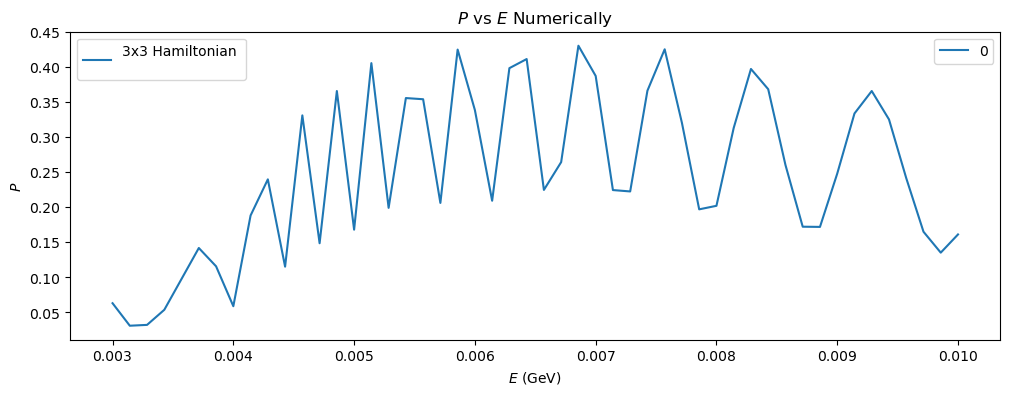

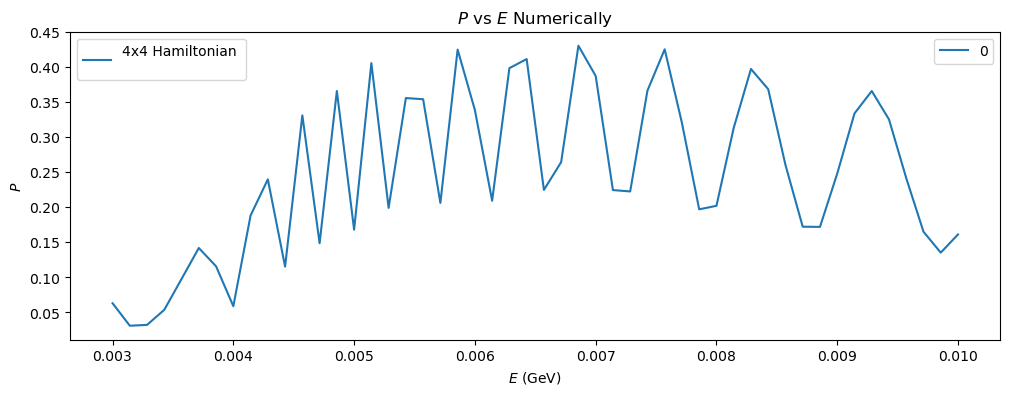

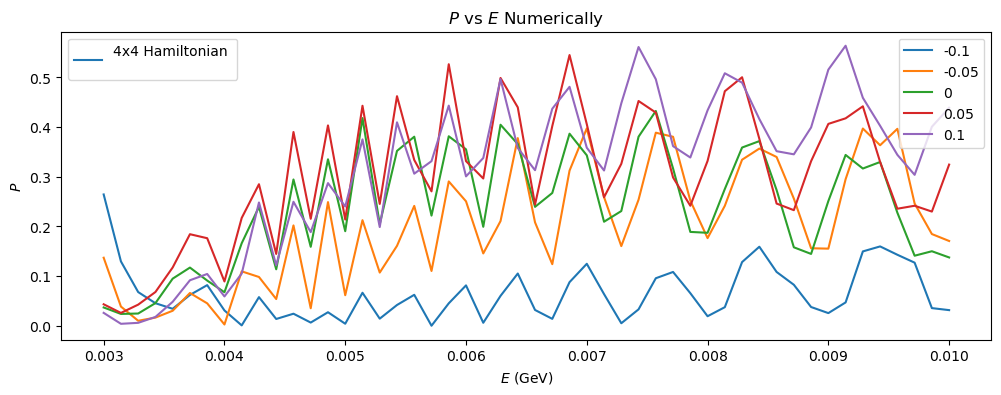

In [9]:
# Numeric Variables

# All distances in km

ticks = 50
steps = 50

#2x2 Neutrino mixing matrix
U2 = (ImmutableDenseMatrix(sympy.rot_axis3(theta)).col_del(2).row_del(2))
VA2 = Matrix([[A,0],[0,0]])


ComplexRot = sympy.rot_ccw_axis2(theta13)
ComplexRot[0,2] *= sympy.E**(-I*phase)
ComplexRot[2,0] *= sympy.E**(I*phase)

#3x3 Neutrino mixing matrix
U3 = sympy.rot_axis1(theta23)*ComplexRot*sympy.rot_axis3(theta12)
U3dag = Dagger(U3)
VA3 = Matrix([[A,0,0],[0,0,0],[0,0,0]])

#4x4 Neutrino Mixing Matrix
R23 = sympy.rot_axis1(theta23).row_insert(3,sympy.zeros(1,3)).col_insert(3,Matrix([0,0,0,1]))

R12 = sympy.rot_axis3(theta12).row_insert(3,sympy.zeros(1,3)).col_insert(3,Matrix([0,0,0,1]))

R13 = sympy.rot_ccw_axis2(theta13).row_insert(3,sympy.zeros(1,3)).col_insert(3,Matrix([0,0,0,1]))
R13[2,0] *= sympy.E**(I*phase13)
R13[0,2] *= sympy.E**(-I*phase13)

R34 = sympy.rot_axis1(theta34).row_insert(0,sympy.zeros(1,3)).col_insert(0,Matrix([1,0,0,0]))

R24 = sympy.rot_axis1(theta24).row_insert(2,sympy.zeros(1,3)).col_insert(2,Matrix([0,0,1,0]))
R24[1,3] *= sympy.E**(-I*phase24)
R24[3,1] *= sympy.E**(I*phase24)

R14 = sympy.rot_ccw_axis2(theta14).row_insert(2,sympy.zeros(1,3)).col_insert(2,Matrix([0,0,1,0]))
R14[3,0] *= sympy.E**(-I*phase14)
R14[0,3] *= sympy.E**(I*phase14)

U4 = R34*R24*R14*R23*R13*R12

#Potentials
VA4 = Matrix([[A,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
VS = Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,S]])

#Analytic solution for 3x3 case
Psol = U3dag[0,1]*U3[0,0] + U3dag[1,1]*U3[0,1]*sympy.E**(-I*delta21*L/(2*E)) + U3dag[2,1]*U3[0,2]*sympy.E**(-I*delta31*L/(2*E))
Pconjsol = conj(Psol)
P2sol = Psol*Pconjsol
lam_P2 = lambdify([theta12,theta13,theta23,E,A,L,phase,delta21,delta31],P2sol)

deltam = 8*10**(-5)

deltam21 = 8*10**(-5)

deltam32 = 2*10**(-3)

deltam31 = deltam32+deltam21

deltam41 = 1*10**(-2)

Eval = 1
Evals = list(np.linspace(3*10**(-3),10**(-2),num =ticks))

Lval = 100

#fthetaval = (pi/6)

theta12val = 0.588
theta13val = 0.149
theta23val = 0.847

theta14val = 0.193
theta24val = 2.99
theta34val = 2.94

phase14val = 0.893
phase13val = 3.09
phase24val = 1.94


lam_U4dag = lambdify([theta12,theta23,theta13,theta14,theta24,theta34,phase13,phase24,phase14,delta21,delta31,delta41,E,S],Dagger(U4))
MassEB = lam_U4dag(theta12val,theta23val,theta13val,theta14val,theta24val,theta34val,phase13val,phase24val,phase14val,deltam21,deltam31,deltam41,E,S)

#3x3 Hamiltonian
H3 = Hamiltonian(U3,sympy.zeros(3,3))

#Lambdified Hamiltonian allows for fast calculations
lam_H3 = lambdify([theta12,theta23,theta13,phase,delta21,delta31,E,A],H3)
H3info = (lam_H3,shape(H3)[0])

#4x4 Hamiltonian
H4 = Hamiltonian(U4,VS)

lam_H4 = lambdify([theta12,theta23,theta13,theta14,theta24,theta34,phase13,phase24,phase14,delta21,delta31,delta41,E,S],H4)
H4info = (lam_H4,shape(H4)[0])


#Mass eigenstates for 4x4 case
PSI1 = MassEB[:,0]
PSI2 = MassEB[:,1]
if shape(MassEB)[0] > 2:
    PSI3 = MassEB[:,2]
    if shape(MassEB)[0] > 3:
        PSI4 = MassEB[:,3]

V = 0.05


probabilityplotter(H3info,(theta12val,theta23val,theta13val),phase13val,(deltam21,deltam31),Evals,0,Lval,PSImu,PSIe)
probabilityplotter(H4info,(theta12val,theta23val,theta13val,0,0,0),(phase13val,0,0),
                   (deltam21,deltam31,0), Evals,[0],Lval,PSImu,PSIe)
probabilityplotter(H4info,(theta12val,theta23val,theta13val,theta14val,theta24val,theta34val),(phase13val,phase24val,phase14val),
                   (deltam21,deltam31,deltam41), Evals,[2*-V,-V,0,V,2*V],Lval,PSImu,PSIe)


